In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb

import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

LOCAL = False
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    RE = os.path.join(PATH, "results")
    CONFIG_NAME="config.local.neuron.mpra.ini"
else:
    PATH="/wynton/group/ahituv/biomarin/data"
    RE = "/wynton/group/ahituv/biomarin/results"
    RE_MAPS = os.path.join(RE, "enh_maps")
    CONFIG_NAME="config.neuron.mpra.orig.ini"
import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
config, cfn = crw.read(CONFIG_NAME)

section = 'lib2'
crw.check(config, section)

In [3]:
if "fasta" not in list(config[section]):  # write files to config

    MPRA = os.path.join(PATH, "delta_rank.csv")

    FASTA = os.path.join(PATH, "library_2", "Design",
                         "biomarin-lib2-hg38-final.fasta")
    META_DATA = os.path.join(PATH, "lib2.meta_data.tsv")

    DELTA_ACTIVITY = os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
    DELTA_ACTIVITY_Z = os.path.join(PATH, "deltaMPRA.gaba.minus.glut.zscore.tsv")
    SIG_ACTIVITY_Z = os.path.join(PATH, "WilcoxonSig.gaba.glut.zscore.tsv")
    VISTA = os.path.join(PATH, "vista.lib2.tiles.bed")

    # delta MPRA activity
    config[section]["delta.mpra_richa"] = MPRA
    config[section]["delta.mpra_centered"] = DELTA_ACTIVITY
    config[section]["delta.mpra_centeredz"] = DELTA_ACTIVITY_Z

    config[section]["fasta"] = FASTA

    # genome coordinates
    config[section]["tile_bed"] = TILE_BED
    config[section]["enh_bed"] = ENH_BED

    # GREAT
    config[section]["great_nearest"] = GREAT_GENE_TSV

    # meta_data
    config[section]["metadata"] = META_DATA

    # significance GABA v. GLUT
    config[section]["sig-wilcoxon"] = SIG_ACTIVITY_Z

    # vista
    config[section]["vista"] = VISTA
    crw.write(config, cfn)

else:
    MPRA = config[section]["delta.mpra_richa"]
    DELTA_ACTIVITY = config[section]["delta.mpra_centered"]
    DELTA_ACTIVITY_Z = config[section]["delta.mpra_centeredz"]

    FASTA = config[section]["fasta"]

    TILE_BED = config[section]["tile_bed"]
    ENH_BED = config[section]["enh_bed"]

    GREAT_GENE_TSV = config[section]["great_nearest"]
    META_DATA = config[section]["metadata"]

    SIG_ACTIVITY_Z = config[section]["sig-wilcoxon"]
    VISTA = config[section]["vista"]

# load MPRA data

In [4]:
meta = pd.read_csv(META_DATA, sep='\t', usecols = ["name", "sequence", "bkgd", "enh.id"])
delta = pd.read_csv(DELTA_ACTIVITY_Z, sep='\t')

len(set(meta["enh.id"]))

1828

In [5]:
delta.loc[delta['name'].str.contains("seq")]

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.699699,-1.696544,-1.003154,0.119390,0.923032
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.683608,-1.740263,-0.943346,0.493535,0.306682
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",False,False,False,False,-2.228061,-1.842682,-0.385379,0.728743,0.137425
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.666574,-1.554678,-1.111896,0.364764,0.437989
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,silencing,False,False,-2.756752,-2.505154,-0.251599,0.801537,0.096076
...,...,...,...,...,...,...,...,...,...,...
963,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,False,False,False,False,-2.266772,-2.040998,-0.225774,0.415113,0.381834
964,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,silencing,False,False,True,-2.389996,-2.005033,-0.384963,0.310392,0.508090
965,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,False,False,False,False,-2.333676,-2.258294,-0.075381,0.745305,0.127666
966,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,silencing,False,False,True,-2.687312,-1.752190,-0.935122,0.332588,0.478094


In [6]:
delta.shape

(35371, 10)

## filter to keep only synthetics

In [8]:
delta.loc[(delta['name'].str.contains("seq")) |
          (delta['name'].str.contains("shuf"))
          ].copy()

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.699699,-1.696544,-1.003154,0.119390,0.923032
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.683608,-1.740263,-0.943346,0.493535,0.306682
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",False,False,False,False,-2.228061,-1.842682,-0.385379,0.728743,0.137425
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.666574,-1.554678,-1.111896,0.364764,0.437989
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,silencing,False,False,-2.756752,-2.505154,-0.251599,0.801537,0.096076
...,...,...,...,...,...,...,...,...,...,...
35366,shuffle_94_chr15:32646056-32646326,False,False,False,False,0.291091,0.028631,0.262459,0.126663,0.897350
35367,shuffle_95_chr19:13408968-13409238,False,False,False,False,0.265764,-0.238704,0.504468,0.168470,0.773478
35368,shuffle_96_chr13:58618367-58618637,False,False,False,False,0.200112,0.027704,0.172408,0.486513,0.312905
35369,shuffle_98_chr3:12869018-12869288,False,False,False,False,-0.385766,-0.596119,0.210353,0.528655,0.276828


In [25]:
deltasyn = delta.loc[delta['name'].str.contains("seq")].copy()


print(deltasyn.shape)
deltasyn.head()

(968, 10)


,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.699699,-1.696544,-1.003154,0.119390,0.923032
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.683608,-1.740263,-0.943346,0.493535,0.306682
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",False,False,False,False,-2.228061,-1.842682,-0.385379,0.728743,0.137425
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.666574,-1.554678,-1.111896,0.364764,0.437989
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,silencing,False,False,-2.756752,-2.505154,-0.251599,0.801537,0.096076


[Text(0.5, 1.0, 'synthetics - delta MPRA')]

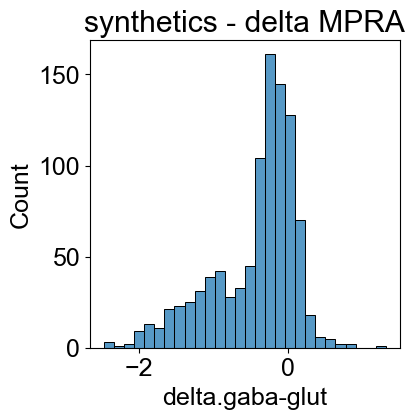

In [28]:
fig, ax = plt.subplots(figsize=(4,4))
sns.histplot(deltasyn["delta.gaba-glut"])
ax.set(title="synthetics - delta MPRA")
     
#plt.savefig(os.path.join(RE, "deltas.syn.pdf"), bbox_inches="tight")

In [30]:
deltasyn["delta.gaba-glut"].describe()

count    968.000000
mean      -0.431155
std        0.565923
min       -2.472881
25%       -0.727779
50%       -0.261088
75%       -0.049817
max        1.320655
Name: delta.gaba-glut, dtype: float64

# filter for shuffled sequences. 
## meta data (library)

In [31]:
enh = meta.loc[meta["bkgd"]==True]

# rename columns for merging with MPRA data
enh.rename(columns ={"start":"start.tile",
                        "end":"end.tile", 
                        "gaba":"gaba_log2_mean", 
                        "glut":"glut_log2_mean"}, 
                        inplace =True
          )

print(enh.shape)
enh.head()

(1296, 4)


,name,sequence,bkgd,enh.id
3791,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893
3792,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893
3793,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893
3794,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893
3795,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893


## MPRA activity

In [32]:
enh = pd.merge(enh, deltasyn, how="left", left_on="name",
               right_on="name").drop_duplicates()
print(enh.shape)
enh.head()

(1296, 13)


,name,sequence,bkgd,enh.id,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr
0,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893,False,False,False,False,-2.277840,-1.724402,-0.553438,0.173911,0.759672
1,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893,False,False,False,False,-1.924076,-1.830802,-0.093274,0.817770,0.087369
2,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893,silencing,False,False,True,-2.371422,-2.039974,-0.331448,0.061749,1.209370
3,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,Background seq2 chr1:244100624-244100893,False,False,False,False,-2.175132,-2.069982,-0.105150,0.591141,0.228309


In [35]:
enh.loc[enh["fdr"]<=0.05].shape

(23, 13)

# add replicates,  significance data

In [36]:
sig_reps= pd.read_csv(SIG_ACTIVITY_Z, sep='\t')
print(sig_reps.shape)
sig_reps.head()

(35371, 11)


,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,0.037107,False,0.119390,0.923032
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,0.361064,False,0.493535,0.306682
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,0.626615,False,0.728743,0.137425
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,0.233208,False,0.364764,0.437989
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,0.719958,False,0.801537,0.096076


### 23 synthetic sequences are significantly different by t-test?

In [37]:
sig_reps.loc[sig_reps["name"].isin(enh['name'])].groupby(["fdr_bool"])["name"].count()

fdr_bool
False    945
True      23
Name: name, dtype: int64

## example of significant, non-significant reps

In [38]:
sig_reps.sample(n=3)

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
27359,chr5:138576150-138576420,0.810647,0.336175,0.720098,0.128940,0.684041,-0.489270,0.266293,False,0.399707,0.398258
9069,chr15:36904943-36905213,0.440820,0.547061,0.345112,0.472333,-0.063216,0.624363,0.684553,False,0.774381,0.111045
29616,chr6:119139116-119139386,0.572793,0.610857,0.626936,0.127535,-0.013875,-0.001782,0.002984,True,0.041622,1.380678


## merge synthetic + rep results

In [39]:
enh= pd.merge(enh, sig_reps, how="left").drop_duplicates()

enh

## plot sig deltas

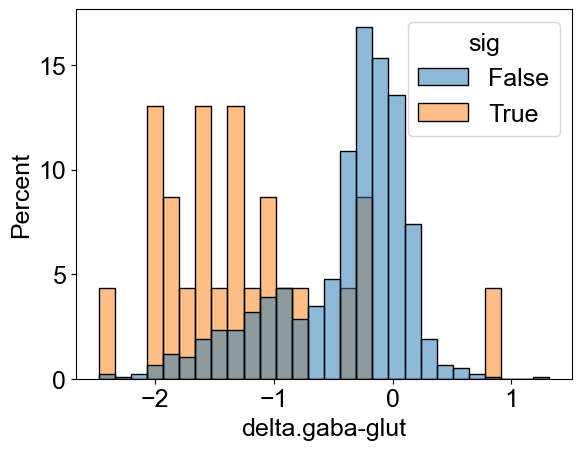

In [41]:
sns.histplot(x="delta.gaba-glut", data=enh, hue="sig", stat="percent", common_norm=False)
out = os.path.join(RE, "delta.dist.syn.sig.only.pdf")
plt.savefig(out, bbox_inches='tight')

## combine significant ttest and celltype_dif (categorical) labels

In [42]:
# remove na elements
enh = enh.loc[~enh["fdr"].isna()]

# Significant activity differences
- four elements are significantly different between cell types, and have categorically different activities. 

In [44]:
enh["sig_n_dif"] = False
enh.loc[(enh["fdr_bool"]==True) & (enh["celltype_dif"]==True), "sig_n_dif"]=True

# print counts
# sig difference (wilcoxon) gaba v. glut
print(enh[["name", "sig"]].drop_duplicates().groupby("sig")['name'].count())

# activity is more extreme than shuffle 95% CI for gaba OR glut, but not both. 
print(enh[["name", "celltype_dif"]].drop_duplicates().groupby("celltype_dif")['name'].count())

# sig difference(wilcoxon) and more extreme than shuffle 95% CI for gaba v. glut
print(enh[["name", "sig_n_dif"]].drop_duplicates().groupby("sig_n_dif")['name'].count())

sig
False    945
True      23
Name: name, dtype: int64
celltype_dif
False    835
True     133
Name: name, dtype: int64
sig_n_dif
False    964
True       4
Name: name, dtype: int64


### four synthetic sequences, significantly reduce activity, GABA more reduced than GLUT
    (n = 4/968; 0.4% of synthetic sequences) 
    Wilcoxon + activity more extreme than shuffle 95% CI for one, but not both cell types. 

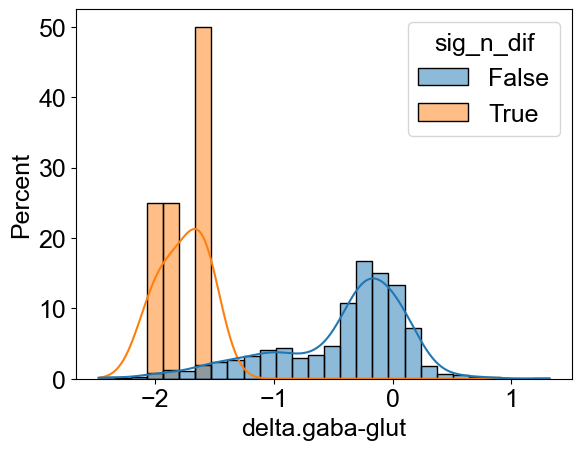

In [20]:
# histogram sig_n_dif
sns.histplot(x="delta.gaba-glut", data=enh, hue="sig_n_dif", kde=True, stat="percent", common_norm=False)
out = os.path.join(RE,"delta.distribution.sig_n_dif.syn.pdf")
plt.savefig(out, bbox_inches='tight')

[Text(0.5, 0, 'mean GLUT'), Text(0, 0.5, 'mean GABA')]

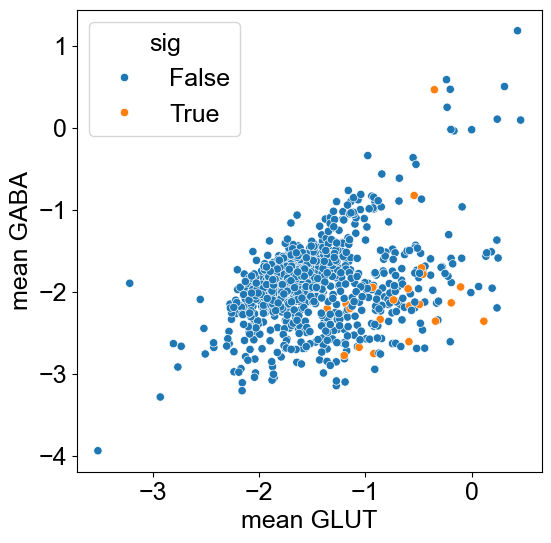

In [46]:
# effect sizes of sig and dif
fig, ax= plt.subplots(figsize=(6,6))
y="gaba" 
x="glut" 
data=enh 
hue="sig"
sns.scatterplot(x=x, y=y, data=data, hue=hue)
out = os.path.join(RE, "cell-type-dif.scatter.syn.pdf")
ax.set(xlabel="mean GLUT", 
      ylabel="mean GABA")
#plt.savefig(out, bbox_inches='tight')

# synthetic design matrix

In [47]:
c, sample_dict = Counter(), {}

for eg in set(enh["name"]):
    # handle str splitting pipe issue
    if "|Motif2" in eg:
        eg = eg.replace("|Motif2", ",Motif2")

    # get information from name w/ pipe str split
    name_info, pos, motif_name, motif = eg.split("|")

    if "chr" in eg:
        template, coor = name_info.split("seq2")
        template = "Background" + "seq2"

    else:
        template, coor = name_info.split("seq1")
        template = "Background" + "seq1"

    # get individual information from comma str split
    pos_list, motifname_list, motifseq_list = pos.split(
        ","), motif_name.split(","), motif.split(",")

    # handle case when two different motifs are inserted.
    if len(motifname_list) == 2 and len(pos_list) == 2:

        # iterate through position indexes
        for n, mpos in enumerate(pos_list):
            mname, mseq = motifname_list[n], motifseq_list[n]
            sample_dict[(eg+f".{n}")] = [eg, template, coor, n,
                                         mpos.strip("Pos").split(":")[1],
                                         mname.split(":")[1],
                                         mseq.split(":")[1],
                                         len(pos_list)
                                         ]  # add to the dictionary

    # else, one motif is inserted multiple times.
    else:
        mname, mseq = motifname_list[0], motifseq_list[0]

        # iterate through positions w/ same motif.
        for n, mpos in enumerate(pos_list):
            sample_dict[(eg+f".{n}")] = [eg, template, coor, n,
                                         mpos.strip("Pos:"),
                                         mname.split(":")[1],
                                         mseq.split(":")[1],
                                         len(pos_list)
                                         ]  # add to the dictionary

            # c[len(motifseq_list)] +=1 # count how many instances of one or two motifs inserts there are.

In [48]:
syn = pd.DataFrame(np.vstack(sample_dict.values())).sort_values(by=7)
syn.columns = ['name', "bkgdseq", "coor", "insert_no",
               "insert_pos", "motif_id", "motif", "insert_n"]
syn

,name,bkgdseq,coor,insert_no,insert_pos,motif_id,motif,insert_n
1324,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,0,135,glutmotif1,TGAACTGCTAGA,1
627,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,0,135,glutmotif2,TGAGTTCTTAAA,1
1969,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,0,135,glutmotif2,TGAGATCTTAAC,1
1325,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,0,135,glutmotif2,TTCCTTATATGT,1
275,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,0,135,glutmotif2,TCAGTTCTTAAC,1
...,...,...,...,...,...,...,...,...
1057,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,1,125,glutmotif2,TTCCTCATGTGT,4
1056,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,0,105,glutmotif2,TTCCTCATGTGT,4
1691,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,Backgroundseq2,chr1:244100624-244100893:+,3,165,glutmotif2,TTCATCATGTGT,4
1065,"Backgroundseq172hr_top_98|Pos:105,125,145,165|...",Backgroundseq1,72hr_top_98,1,125,glutmotif2,TCAGTTCTTAAA,4


In [50]:
# N motif ids
len(set(syn["motif_id"]))

4

In [51]:
set(syn["motif_id"])

{'gabamotif1', 'glutmotif1', 'glutmotif2', 'glutmotif3'}

## Design info 
    
    motifs = 24 
    insert_positions = 7
    max inserts = 4

    motif_ids = 'gabamotif1', 'glutmotif1', 'glutmotif2', 'glutmotif3'

In [56]:
# add dv
if "gaba_log2_mean" not in list(syn):
    syn = pd.merge(syn, enh[["name", 
                   'gaba_log2_mean',
                   'glut_log2_mean',
                   ]], 
         how='left'
        )

# GLUT Activity ~ position, motif



## Activity ~ Position

<Axes: xlabel='insert_pos', ylabel='glut_log2_mean'>

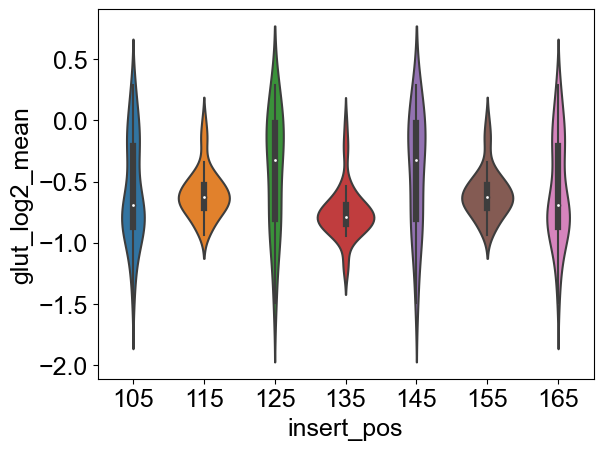

In [143]:
x_vars = ["insert_pos"]
y_var = 'glut_log2_mean'
x_vars.append(y_var)
data = syn[x_vars].drop_duplicates().copy().reset_index()

sns.violinplot(x="insert_pos", y="glut_log2_mean",
               data=data.sort_values(by="insert_pos"))

## Activity ~ motif

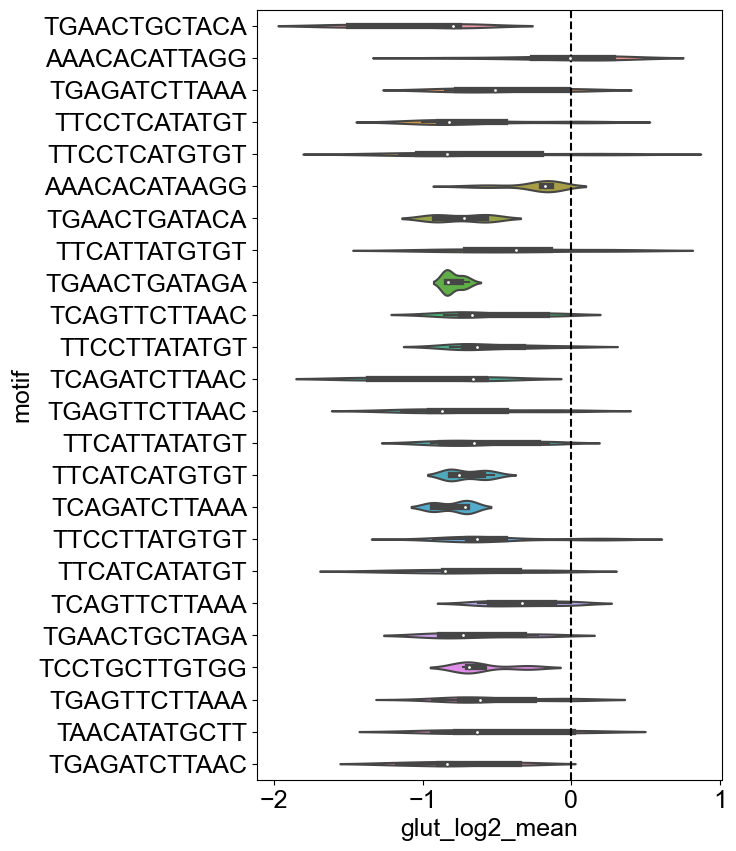

In [171]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.violinplot(x="glut_log2_mean", 
              y='motif', 
              data=syn)
ax.axvline(0, ls="--", c="k")

In [162]:
M = syn.motif
P = syn.insert_pos
y = syn.glut_log2_mean

formula = "y ~ C(M) + C(P)"  #"+ C(M)*C(P)"  # interaction effect - looks horrible
lm = ols(formula, syn).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     4.892
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           3.51e-13
Time:                        14:39:03   Log-Likelihood:                -82.051
No. Observations:                 324   AIC:                             224.1
Df Residuals:                     294   BIC:                             337.5
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2629 

# GABA Activity ~ position, motif

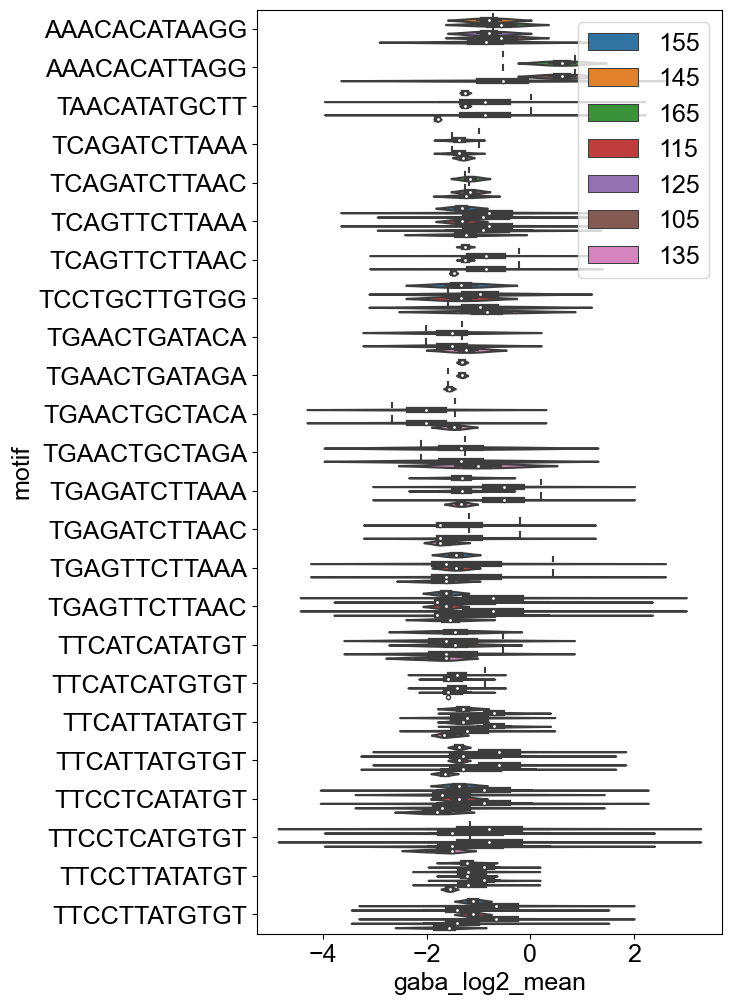

In [148]:
fig, ax = plt.subplots(figsize=(6, 12))
x_vars = ["motif", "insert_pos"]
y_var = 'gaba_log2_mean'
hue = "motif"
x_vars.append(y_var)
data = syn[x_vars].drop_duplicates().copy().reset_index()
sns.violinplot(y=x_vars[0], x=y_var,
               data=data.sort_values(by=x_vars[0]), 
              hue=x_vars[1])
ax.legend(bbox_to_anchor = (1,1))

In [150]:
data.groupby("motif")["insert_pos"].count()

motif
AAACACATAAGG    16
AAACACATTAGG    12
TAACATATGCTT    14
TCAGATCTTAAA    12
TCAGATCTTAAC    12
TCAGTTCTTAAA    18
TCAGTTCTTAAC    14
TCCTGCTTGTGG    14
TGAACTGATACA    12
TGAACTGATAGA    10
TGAACTGCTACA    12
TGAACTGCTAGA    12
TGAGATCTTAAA    14
TGAGATCTTAAC    15
TGAGTTCTTAAA    17
TGAGTTCTTAAC    18
TTCATCATATGT    17
TTCATCATGTGT    16
TTCATTATATGT    21
TTCATTATGTGT    18
TTCCTCATATGT    22
TTCCTCATGTGT    17
TTCCTTATATGT    18
TTCCTTATGTGT    21
Name: insert_pos, dtype: int64

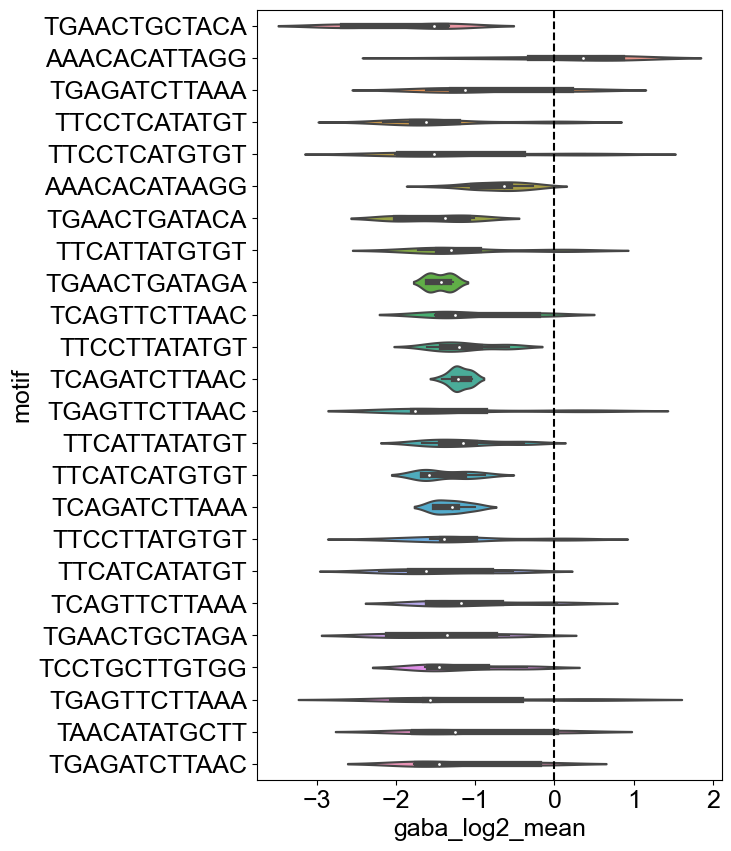

In [172]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.violinplot(x="gaba_log2_mean", 
              y='motif', 
              data=syn)
ax.axvline(0, ls="--", c="k")

In [163]:
M = syn.motif
P = syn.insert_pos
y = syn.gaba_log2_mean

formula = "y ~ C(M) + C(P)"  #"+ C(M)*C(P)"  # interaction effect - looks horrible
lm = ols(formula, syn).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     4.174
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           1.10e-10
Time:                        14:39:36   Log-Likelihood:                -295.97
No. Observations:                 324   AIC:                             651.9
Df Residuals:                     294   BIC:                             765.4
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7130 

<Axes: xlabel='insert_pos', ylabel='gaba_log2_mean'>

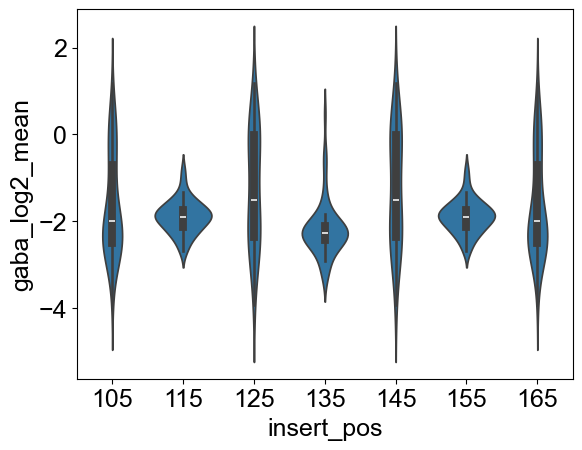

In [69]:
x_vars = ["insert_pos"]
y_var = 'gaba_log2_mean'
x_vars.append(y_var)

data = syn[x_vars].drop_duplicates().copy().reset_index()

sns.violinplot(x=x_vars[0], y=y_var,
               data=data.sort_values(by=x_vars[0]))